# introduction to the vectorizing principle

## part 5b: generating SQL and dataframe transformation code with one syntax - an example pipeline

While pandas is the most popular library for describing data transformations in python, there are more which you will also see in following parts. Relational databases are also a means of highly efficient processing of tabular data. They are typically instructed with a declarative language called SQL which allows for highly sophisticated query engines to first plan how to execute the query. From a large search space of possible execution plans they chose the supposedly best one by using computation cost estimators.

For having a quick look at the data or for searching bugs in previously executed transformation code, it is highly efficient to write ad-hoc SQL scripts by hand. However, for better software engineering practices such as testing, programmatically creating SQL is the preferred option. In fact, it would be ideal to have one syntax from which both dataframe transformation code and SQL can be generated. This is what we show in this part.

The library [pydiverse.transform](https://github.com/pydiverse/pydiverse.transform/) is used here even though it is early stage and still lacks essential features. It is intended as a proof of concept for this idea.

Pandas uses the fluent interface technique chaining functional methods with multiple function calls: `df.assign(x=lambda df: df.int_col*2).loc[lambda df: df.x == 4]`

pydiverse.transform uses the pipe syntax instead, similar to its precursors [dplyr from R](https://dplyr.tidyverse.org/) and [siuba](https://siuba.org/): `df >> mutate(x=λ.int_col*2) >> filter(λ.x == 4)`

pydiverse.transform also supports creating custom verbs with the `@verb` decorator which then can be used within a pipe just like builtin verbs such as `mutate` or `filter`.

Detail: In SQL, joining a table does not add any new columns to the select statement. It rather brings a new table within the namespace that can be used for creating select columns. pydiverse.transform supports this feature by dropping columns with an empty `select()` statement which does not remove them from the namespace for further use in `mutate()` statements.

#### define tasks and helper functions

In [2]:
import os

import pandas as pd
import pydiverse.transform as pdt
import xgboost
import xgboost as xgb
from pydiverse.pipedag import Blob, Flow, Stage, Table, materialize
from pydiverse.transform import aligned, λ
from pydiverse.transform.core.verbs import (
    alias,
    collect,
    filter,
    left_join,
    mutate,
    select,
)
from pydiverse.transform.eager import PandasTableImpl
from pydiverse.transform.lazy import SQLTableImpl


@pdt.verb
def transmute(tbl, **kwargs):
    return tbl >> select() >> mutate(**kwargs)


@pdt.verb
def trim_all_str(tbl):
    for col in tbl:
        if col._.dtype == "str":
            tbl[col] = col.strip()
    return tbl


def pk(x: pdt.Table):
    # This is just a placeholder.
    # Ideally there would be a global function in pydiverse transform to
    # get the primary key (and another one to get the table / col name)
    return x.pk


def pk_match(x: pdt.Table, y: pdt.Table):
    return pk(x) == pk(y)


def get_named_tables(tables: list[pdt.Table]) -> dict[str, pdt.Table]:
    return {tbl._impl.name: tbl for tbl in tables}


@materialize(version="1.0.0")
def read_input_data(src_dir="data/pipedag_example_data"):
    return [
        Table(pd.read_csv(os.path.join(src_dir, file)), name=file.removesuffix(".csv.gz"))
        for file in os.listdir(src_dir)
        if file.endswith(".csv.gz")
    ]


@materialize(input_type=SQLTableImpl, lazy=True)
def clean(src_tbls: list[pdt.Table]):
    return [tbl >> trim_all_str() for tbl in src_tbls]


@materialize(input_type=SQLTableImpl, lazy=True, nout=3)
def transform(src_tbls: list[pdt.Table]):
    named_tbls = get_named_tables(src_tbls)
    a = named_tbls["a"]
    b = named_tbls["b"]
    c = named_tbls["c"]

    def join_b(a):
        return a >> left_join(b >> select(), pk_match(a, b))

    new_a = join_b(a) >> mutate(x=b.x)
    new_b = b
    new_c = c

    return new_a, new_b, new_c


@materialize(input_type=SQLTableImpl, lazy=True)
def lazy_features(a: pdt.Table, src_tbls: list[pdt.Table]):
    named_tbls = get_named_tables(src_tbls)
    b = named_tbls["b"]
    return (
        a
        >> left_join(b, pk_match(a, b))
        >> transmute(pk=pk(a), aiige=a.age, y=b.y, z=b.z * 2)
        >> alias("lazy_features")
    )


@materialize(input_type=PandasTableImpl, version="2.3.5")
def eager_features(a: pdt.Table, src_tbls: list[pdt.Table]):
    named_tbls = get_named_tables(src_tbls)
    c = named_tbls["c"]
    return (
        a
        >> left_join(c, pk_match(a, c))
        >> transmute(pk=pk(a), xx=c.x, yy=c.y * 2, zz=c.z + 3)
        >> alias("eager_features")
    )


@materialize(input_type=SQLTableImpl, lazy=True)
def combine_features(features1: pdt.Table, features2: pdt.Table):
    return (
        features1
        >> left_join(
            features2 >> select(-pk(features2)), pk_match(features1, features2)
        )
        >> alias("features")
    )


@materialize(input_type=SQLTableImpl, lazy=True, nout=2)
def train_and_test_set(flat_table: pdt.Table, features: pdt.Table):
    tbl = (
        flat_table
        >> left_join(features, pk_match(flat_table, features))
        >> mutate(row_num=pdt.functions.row_number(arrange=[pk(flat_table)]))
        >> select(-pk(flat_table), -pk(features))
    )

    training_set = (
        tbl
        >> filter(λ.row_num % 10 != 0)
        >> select(-λ.row_num)
        >> alias("training_set")
    )
    test_set = (
        tbl >> filter(λ.row_num % 10 == 0) >> select(-λ.row_num) >> alias("test_set")
    )

    return (training_set, test_set)


@materialize(input_type=pd.DataFrame, version="4.5.8")
def model_training(train_set: pd.DataFrame):
    x = train_set.drop("target", axis=1)
    y = train_set["target"]
    dtrain = xgb.DMatrix(x, label=y)

    params = {"max_depth": 2, "eta": 1, "objective": "binary:logistic"}
    model = xgb.train(params, dtrain)

    return Blob(model, "model")


@aligned(with_="test_set")
def predict(model: xgboost.Booster, test_set: pdt.Table):
    x = test_set >> select(-λ.target) >> collect()

    # Ugly hack to convert new pandas dtypes to numpy dtypes, because xgboost
    # requires numpy dtypes.
    x = x.astype(
        x.dtypes.map(lambda d: d.numpy_dtype if hasattr(d, "numpy_dtype") else d)
    )

    dx = xgb.DMatrix(x)
    predict_col = model.predict(dx)

    return pdt.Table(
        PandasTableImpl("prediction", pd.DataFrame({"prediction": predict_col}))
    ).prediction


@materialize(input_type=PandasTableImpl, version="3.4.5")
def model_evaluation(model: xgboost.Booster, test_set: pdt.Table):
    prediction = predict(model, test_set)  # produces an aligned vector with input
    return (
        test_set
        >> select(λ.target)
        >> mutate(prediction=prediction)
        >> mutate(abs_error=abs(λ.target - λ.prediction))
        >> alias("evaluation")
    )

#### define pipeline:

In [3]:
def get_pipeline():
    with Flow("flow") as flow:
        with Stage("1_raw_input"):
            raw_tbls = read_input_data()

        with Stage("2_clean_input"):
            clean_tbls = clean(raw_tbls)

        with Stage("3_transformed_data"):
            a, b, c = transform(clean_tbls)

        with Stage("4_features"):
            features1 = lazy_features(a, [a, b, c])  # s3.tbls
            features2 = eager_features(a, [a, b, c])  # s3.tbls
            features = combine_features(features1, features2)

        with Stage("5_model"):
            train_set, test_set = train_and_test_set(a, features)
            model = model_training(train_set)

        with Stage("6_evaluation"):
            _ = model_evaluation(model, test_set)

    return flow

#### setup logging:

In [4]:
import logging
from pydiverse.pipedag.util.structlog import setup_logging
setup_logging(log_level=logging.INFO)

#### run pipeline:

2023-08-06 12:16:48.984534 [info     ] Initialized SQL Table Store    [DuckDBTableStore] engine_url=duckdb:////tmp/pipedag/vectorization/db.duckdb schema_prefix= schema_suffix=
2023-08-06 12:16:48.989155 [info     ] Starting IPCServer             [RunContextServer] address=tcp://127.0.0.1:41715
2023-08-06 12:16:48.995797 [info     ] Initialized SQL Table Store    [DuckDBTableStore] engine_url=duckdb:////tmp/pipedag/vectorization/db.duckdb schema_prefix= schema_suffix=
2023-08-06 12:16:49.013481 [info     ] Executing sql                  [DuckDBTableStore] 
    [query]
    CREATE SCHEMA IF NOT EXISTS pipedag_metadata
2023-08-06 12:16:49.025376 [info     ] Executing sql                  [DuckDBTableStore] 
    [query]
    CREATE SCHEMA IF NOT EXISTS "1_raw_input"
2023-08-06 12:16:49.027244 [info     ] Executing sql                  [DuckDBTableStore] 
    [query]
    DROP SCHEMA IF EXISTS "1_raw_input__even" CASCADE
2023-08-06 12:16:49.029435 [info     ] Executing sql                  [D

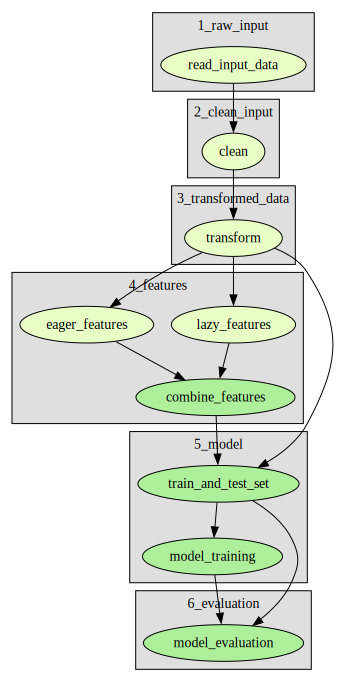

In [6]:
flow = get_pipeline()
result = flow.run()
result.visualize()
assert result.successful

Next: [vectorization06.ipynb](vectorization06.ipynb): many ways to describe data transformations in python